In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import h5py
import os

from synsets import load_syn_data, det_clsloc_names
from val_data import load_val_database, ValImage, ObjectAnnotation
from data_loader import ValDataLoader
from val_utils import get_db_image

from model_data import *

import cv2

from bounding_boxes import *
import seaborn as sns
from tabulate import tabulate

Using TensorFlow backend.


In [2]:
sns.set_style("white")
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
#     sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"],
        
    })
    


set_style()

In [3]:
results = "../results/"
bb_folder = "../bounding_boxes/"
db_bb_file = os.path.join(bb_folder, "bb_center_010.h5")
results_file = os.path.join(results, "preds_resnet50_original.h5")
# Load databases
syn_data = load_syn_data()
db = load_val_database(syn_data)
models = load_model_results(syn_data, db)

Loaded DET data
Loaded CLSLOC data
Computed relation between CLSLOC and DET.
Loading Keras imagenet class index
Loading validation data...
Data loaded! 20121 images
Finding val images with only one object..
One object database built: 7706 images
Loading ground truth labels...
Loaded!
Computing image distribution in each of the 200 categories...
Done!
Processing model resnet50
DONE! Processing model resnet50
Processing model inceptionv3
DONE! Processing model inceptionv3
Processing model vgg16
DONE! Processing model vgg16
Processing model vgg19
DONE! Processing model vgg19
Processing model alexnet
DONE! Processing model alexnet
All models processed!!


## Aux Functions

In [4]:
def line_acc_plot(ax, model_names, datas, title, relative=False):
    sns.set(font_scale=1.4)
    sns.set_style("white")
    accs1 = [[100*models[mn].datasets[ds].all.top1_acc(relative) for ds in datas] for mn in model_names]
    accs5 = [[100*models[mn].datasets[ds].all.top5_acc(relative) for ds in datas] for mn in model_names]

    occ = [0, 10, 20, 50, 75, 100]
    occ = occ[:len(datas)]
    prop_iter = iter(plt.rcParams['axes.prop_cycle'])

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Occlusion %')
    ax.set_xticks(np.arange(0,110,10))
    ax.set_title('Center Occlusion Absolute Accuracy')
    ax.set_title('{} ({})'.format(title,'Relative' if relative else 'Absolute'))
    ax.set_ylim([0,105])
    ax.set_xlim([-2,105])
    
    ax.grid('on')

    h = []
    for mn, a1, a5 in zip(model_names, accs1, accs5):
        color=next(prop_iter)['color']
        ax.plot(occ, a1,'.--', color=color)
        h.append(ax.plot(occ, a5,'o-', color=color))
    ax.legend([han[0] for han in h], model_names)
    sns.despine()
    return ax


def line_series_plot(ax, series_names, series_data, title):
    sns.set(font_scale=1.4)
    sns.set_style("white")
    occ = [0, 10, 20, 50, 75, 100]
    num_points = len(series_data[0][0])
    occ = occ[:num_points]
    
    prop_iter = iter(plt.rcParams['axes.prop_cycle'])

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Occlusion %')
    ax.set_xticks(np.arange(0,110,10))
    ax.set_title('Center Occlusion Absolute Accuracy')
    ax.set_title(title)
    ax.set_ylim([0,105])
    ax.set_xlim([-2,105])
    
    ax.grid('on')

    h = []
    for mn, (a1, a5) in zip(series_names, series_data):
        color=next(prop_iter)['color']
        ax.plot(occ, a1,'.--', color=color)
        h.append(ax.plot(occ, a5,'o-', color=color))
    ax.legend([han[0] for han in h], series_names)
    sns.despine()
    return ax

def categories_plot(ax, mn, ds, title, relative=True, top="top1"):
    if top=="top1":
        acc = lambda x,r: x.top1_acc(r)
        ttop = "Top 1"
    else:
        acc = lambda x,r: x.top5_acc(r)
        ttop = "Top 5"
                    
    # Progression across categories    
    all_ds = ["original"] + ["bb_{}_{:03d}".format(ds,i) for i in [10, 20, 50, 75]] + ["bb_center_100"]
    cats = sorted(filter(lambda x: x.num_top1(relative) >= 20 and x.num_top1(True)>=5, models[mn].datasets[all_ds[-3]].categories.values()),
                  key=lambda x:acc(x,relative), reverse=False)

    cats = list(map(lambda x: x.idx, cats))
    sns.set(font_scale=1.4)
    sns.set_style("white")
    accs = [[100*acc(models[mn].datasets[d].categories[idx], relative) for d in all_ds] for idx in cats]

    occ = [0, 10, 20, 50, 75, 100]
    occ = occ[:len(accs[0])]

    ax.set_ylabel('Relative Accuracy' if relative else 'Accuracy')
    ax.set_xlabel('Occlusion %')
    ax.set_xticks(np.arange(0,110,10))
    ax.set_title("{} {}".format(ttop, title))
    ax.set_ylim([0,105])
    ax.set_xlim([-2,105])

    ax.grid('on')

    h = []
    # with sns.color_palette("Blues", len(cats)):
    with sns.color_palette("RdBu", len(cats)):
        prop_iter = iter(plt.rcParams['axes.prop_cycle'])
        for c, a in zip(cats, accs):
            color=next(prop_iter)['color']
            ax.plot(occ, a,'o-', color=color)
        sns.despine()
        
    return ax, cats

def draw_horizontal_line(ax, x, y, **kwargs):
    kwargs.setdefault('linewidth',3.0)
    kwargs.setdefault('color', 'k')
    return ax.plot(x, [y, y], **kwargs)

def draw_random_chance(ax, x = [-10, 110]):
    ax.text(0,18,'Top 5 RC', fontsize=15)
    ax.text(0,7,'Top 1 RC', fontsize=15)
    draw_horizontal_line(ax,x, 100*db.random_chance_top5, linewidth=1)
    draw_horizontal_line(ax,x, 100*db.random_chance_top1, linewidth=1, linestyle='--')

def get_models_acc(model_names, datas, relative=False):
    accs1 = [[100*models[mn].datasets[ds].all.top1_acc(relative) for ds in datas] for mn in model_names]
    accs5 = [[100*models[mn].datasets[ds].all.top5_acc(relative) for ds in datas] for mn in model_names]
    return list(zip(accs1, accs5))

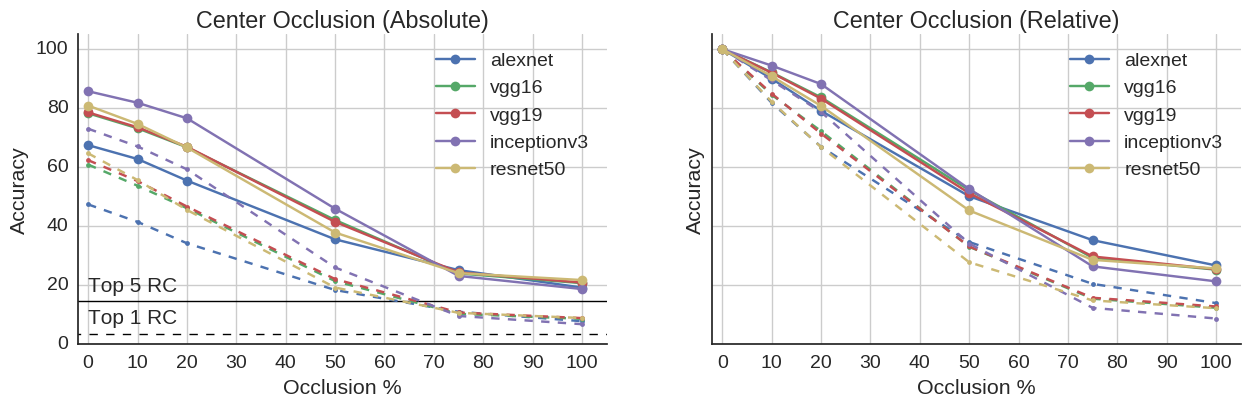

In [7]:
model_names = ['alexnet', 'vgg16','vgg19','inceptionv3','resnet50']
datas = ['original', 'bb_center_010', 'bb_center_020', 'bb_center_050', 'bb_center_075', 'bb_center_100']
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,4))
draw_random_chance(ax[0])
line_series_plot(ax[0], model_names, get_models_acc(model_names, datas, relative=False), 'Center Occlusion (Absolute)')
line_series_plot(ax[1], model_names, get_models_acc(model_names, datas, relative=True), 'Center Occlusion (Relative)')


# Comparison tables

## Overall without occlusion -- comparison within models

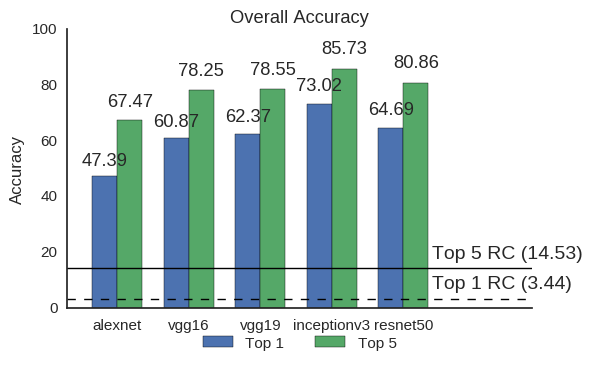

In [29]:
model_names = ['alexnet', 'vgg16','vgg19','inceptionv3','resnet50']
ds = 'original'
accs1 = [100*models[mn].datasets[ds].all.top1_acc(False) for mn in model_names]
accs5 = [100*models[mn].datasets[ds].all.top5_acc(False) for mn in model_names]
# print(*zip(model_names,accs))

N = len(model_names)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
offset = width

current_palette = sns.color_palette()
sns.set(font_scale=1.1)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6,4))
#with sns.color_palette("husl", 8):
prop_iter = iter(plt.rcParams['axes.prop_cycle'])
rects1 = ax.bar(offset+ind, accs1, width, color=next(prop_iter)['color'])
rects2 = ax.bar(offset+ind + width, accs5, width, color=next(prop_iter)['color'])

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Overall Accuracy')
ax.set_xticks(offset+ind + width)
ax.set_xticklabels(model_names)

# ax.legend((rects1[0], rects2[0]), ('Top 1', 'Top 5'),loc=0,
#          ncol=2)

ax.text(5.1,18,'Top 5 RC ({:.2f})'.format(100*db.random_chance_top5), fontsize=14)
ax.text(5.1,7,'Top 1 RC ({:.2f})'.format(100*db.random_chance_top1), fontsize=14)
draw_horizontal_line(ax,[0, 6.5], 100*db.random_chance_top5, linewidth=1)
draw_horizontal_line(ax,[0, 6.5], 100*db.random_chance_top1, linewidth=1, linestyle='--')

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.ylim([0,100])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend((rects1[0], rects2[0]), ('Top 1', 'Top 5'),
          loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)


sns.despine()
plt.savefig('../figures/overall_acc.pdf',bbox_inches='tight')
plt.show()


In [261]:
ds='original'
for mn in model_names:
    acc = models[mn].datasets[ds].all.top5_acc(False)
    print("{}: {:.2f}% accuracy".format(mn, acc*100))
    
print(100*db.random_chance_top1, 100*db.random_chance_top5)

alexnet: 67.47% accuracy
vgg16: 78.25% accuracy
vgg19: 78.55% accuracy
inceptionv3: 85.73% accuracy
resnet50: 80.86% accuracy
3.44098105372 14.5343575349


## Overall with occlusion types (trend lines)

### Center occlusion (absolute)

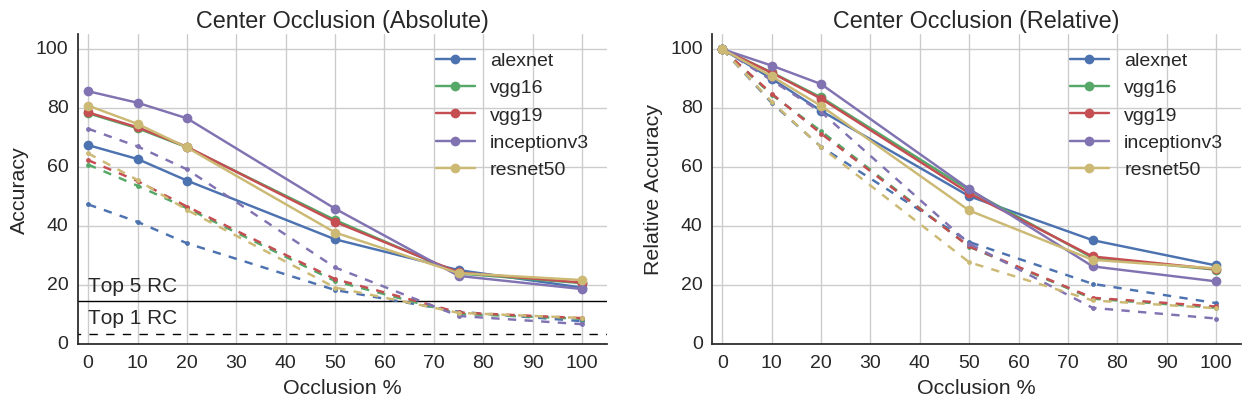

In [292]:
model_names = ['alexnet', 'vgg16','vgg19','inceptionv3','resnet50']
datas = ['original', 'bb_center_010', 'bb_center_020', 'bb_center_050', 'bb_center_075', 'bb_center_100']
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,4))
_ = draw_random_chance(ax[0])
line_series_plot(ax[0], model_names, get_models_acc(model_names, datas, relative=False), 'Center Occlusion (Absolute)')
line_series_plot(ax[1], model_names, get_models_acc(model_names, datas, relative=True), 'Center Occlusion (Relative)')
_ = ax[1].set_ylabel('Relative Accuracy') 
# fig.savefig('../figures/center_overall.pdf',bbox_inches='tight')


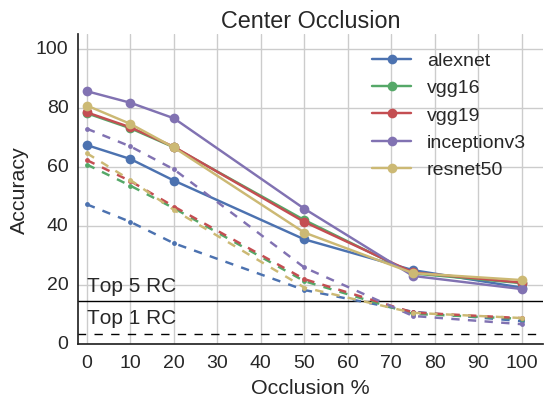

In [11]:
model_names = ['alexnet', 'vgg16','vgg19','inceptionv3','resnet50']
datas = ['original', 'bb_center_010', 'bb_center_020', 'bb_center_050', 'bb_center_075', 'bb_center_100']
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4))
draw_random_chance(ax)
line_series_plot(ax, model_names, get_models_acc(model_names, datas, relative=False), 'Center Occlusion')
# line_series_plot(ax[1], model_names, get_models_acc(model_names, datas, relative=True), 'Center Occlusion (Relative)')
fig.savefig('../figures/center_overall_abs.pdf',bbox_inches='tight')

### Corner

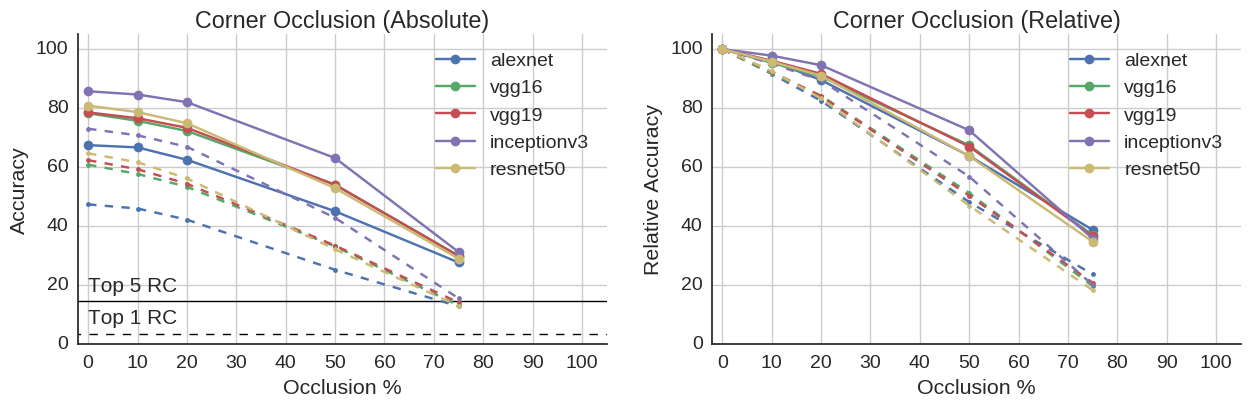

In [293]:
model_names = ['alexnet', 'vgg16','vgg19','inceptionv3','resnet50']
datas = ['original', 'bb_corner_010', 'bb_corner_020', 'bb_corner_050', 'bb_corner_075']
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,4))
_ = draw_random_chance(ax[0])
line_series_plot(ax[0], model_names, get_models_acc(model_names, datas, relative=False), 'Corner Occlusion (Absolute)')
line_series_plot(ax[1], model_names, get_models_acc(model_names, datas, relative=True), 'Corner Occlusion (Relative)')
_ = ax[1].set_ylabel('Relative Accuracy')
# fig.savefig('../figures/corner_overall.pdf',bbox_inches='tight')

## Random

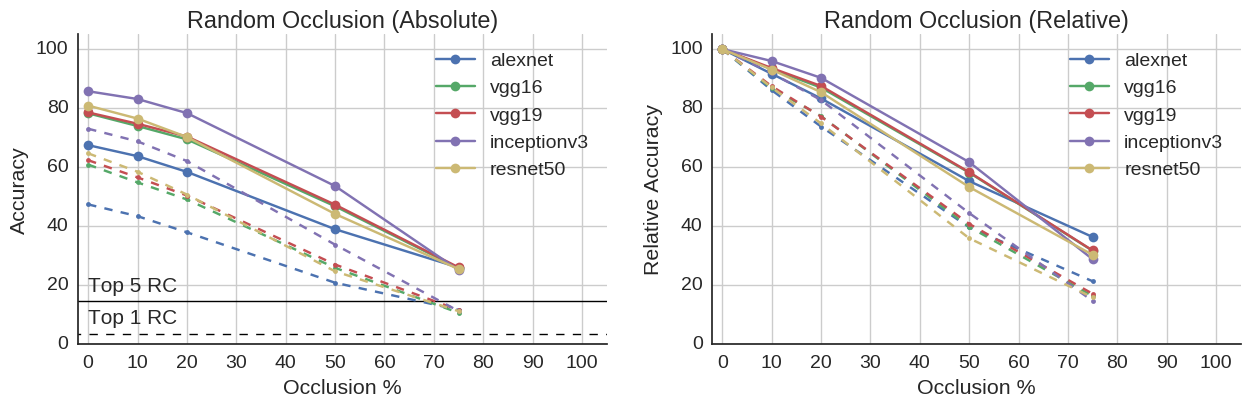

In [294]:
model_names = ['alexnet', 'vgg16','vgg19','inceptionv3','resnet50']
datas = ['original', 'bb_random_010', 'bb_random_020', 'bb_random_050', 'bb_random_075']
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,4))
_ = draw_random_chance(ax[0])
line_series_plot(ax[0], model_names, get_models_acc(model_names, datas, relative=False), 'Random Occlusion (Absolute)')
line_series_plot(ax[1], model_names, get_models_acc(model_names, datas, relative=True), 'Random Occlusion (Relative)')
_ = ax[1].set_ylabel('Relative Accuracy')
# fig.savefig('../figures/random_overall.pdf',bbox_inches='tight')

## Occlusion types in one model

In [13]:
def get_model_occ_type_data(mn, series, relative):
    original = ([100*models[mn].datasets["original"].all.top1_acc(relative)],
                [100*models[mn].datasets["original"].all.top5_acc(relative)])
    full = ([100*models[mn].datasets["bb_center_100"].all.top1_acc(relative)],
            [100*models[mn].datasets["bb_center_100"].all.top5_acc(relative)])
    series_data = [( original[0] +
                    [100*models[mn].datasets["bb_{}_{}".format(occ_type, pct)].all.top1_acc(relative)
                         for pct in pcts] + full[0],
                    original[1] +
                        [100*models[mn].datasets["bb_{}_{}".format(occ_type, pct)].all.top5_acc(relative)
                         for pct in pcts] + full[1])
                        for occ_type in series]
    return series_data

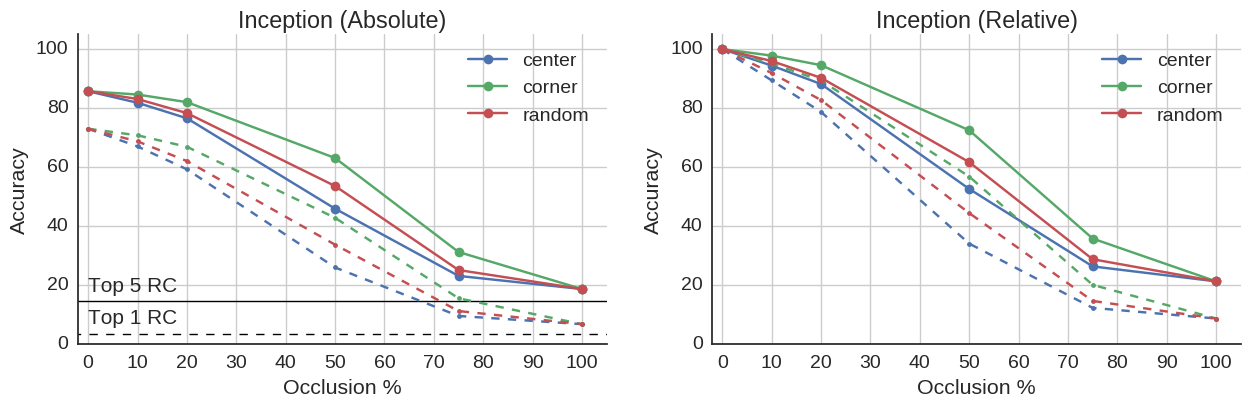

In [295]:
mn = 'inceptionv3'
series = ['center','corner','random']
pcts = ['010','020','050','075']
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,4))
_ = draw_random_chance(ax[0])
line_series_plot(ax[0], series,  get_model_occ_type_data(mn, series, False), 'Inception (Absolute)')
line_series_plot(ax[1], series,  get_model_occ_type_data(mn, series, True), 'Inception (Relative)')
# fig.savefig('../figures/inception_overall.pdf',bbox_inches='tight')

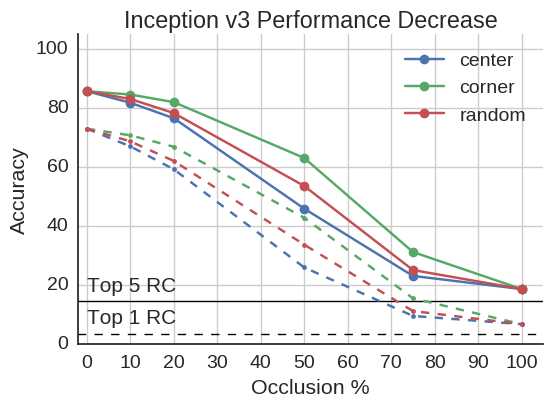

In [17]:
mn = 'inceptionv3'
series = ['center','corner','random']
pcts = ['010','020','050','075']
fig, ax = plt.subplots(1,1, sharey=False, figsize=(6,4))
_ = draw_random_chance(ax)
line_series_plot(ax, series,  get_model_occ_type_data(mn, series, False), 'Inception v3 Performance Decrease')
# line_series_plot(ax[1], series,  get_model_occ_type_data(mn, series, True), 'Inception (Relative)')
fig.savefig('../figures/inception_overall_abs.pdf',bbox_inches='tight')

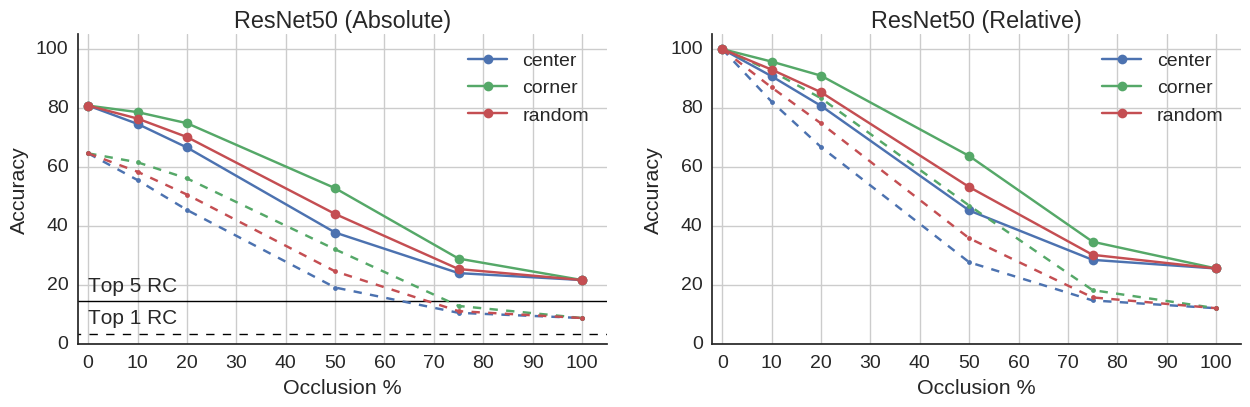

In [296]:
mn = 'resnet50'
series = ['center','corner','random']
pcts = ['010','020','050','075']
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,4))
_ = draw_random_chance(ax[0])
line_series_plot(ax[0], series,  get_model_occ_type_data(mn, series, False), 'ResNet50 (Absolute)')
line_series_plot(ax[1], series,  get_model_occ_type_data(mn, series, True), 'ResNet50 (Relative)')
# fig.savefig('../figures/resnet_overall.pdf',bbox_inches='tight')

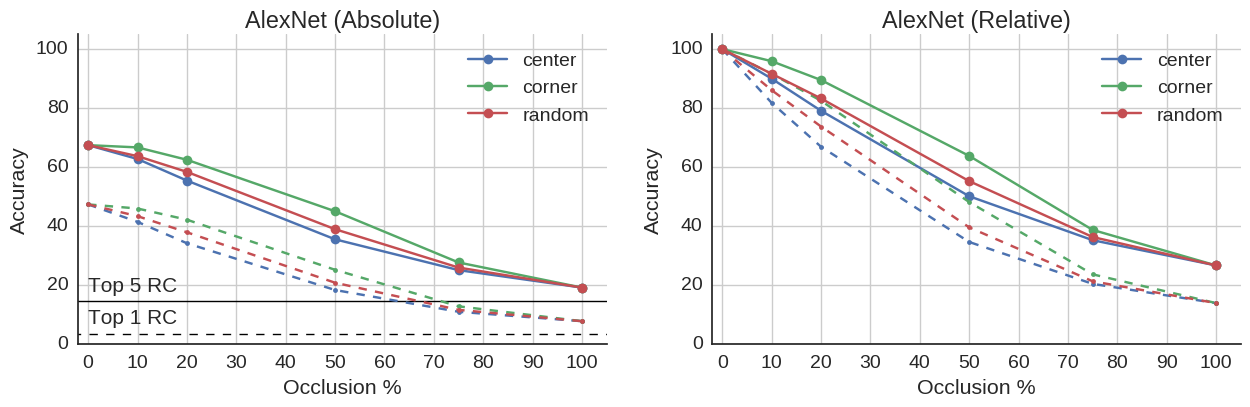

In [297]:
mn = 'alexnet'
series = ['center','corner','random']
pcts = ['010','020','050','075']
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,4))
_ = draw_random_chance(ax[0])
line_series_plot(ax[0], series,  get_model_occ_type_data(mn, series, False), 'AlexNet (Absolute)')
line_series_plot(ax[1], series,  get_model_occ_type_data(mn, series, True), 'AlexNet (Relative)')
# fig.savefig('../figures/alexnet_overall.pdf',bbox_inches='tight')

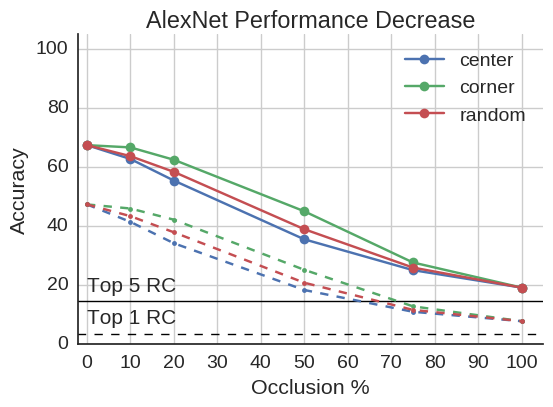

In [18]:
mn = 'alexnet'
series = ['center','corner','random']
pcts = ['010','020','050','075']
fig, ax = plt.subplots(1,1, sharey=False, figsize=(6,4))
_ = draw_random_chance(ax)
line_series_plot(ax, series,  get_model_occ_type_data(mn, series, False), 'AlexNet Performance Decrease')
# line_series_plot(ax[1], series,  get_model_occ_type_data(mn, series, True), 'AlexNet (Relative)')
fig.savefig('../figures/alexnet_overall_abs.pdf',bbox_inches='tight')

# Category Analysis

In [14]:
def top_category_performance(mn, ds, top="top1", relative=False):
    # Find best categories
    # ds = 'bb_center_100'
    # ds = 'bb_random_075'
    if top=="top1":
        acc = lambda x,r: x.top1_acc(r)
        ttop = "Top 1"
        num = lambda x: x.num_top1(relative)
    else:
        acc = lambda x,r: x.top5_acc(r)
        ttop = "Top 5"
        num = lambda x: x.num_top5(relative)
    if relative:
        cond = lambda x: x.num_top1(relative) >= 20 and x.num_top1(True) >=5
    else:
        cond = lambda x: x.num_top1(False) >= 20    
    
    cats = sorted(filter(cond, models[mn].datasets[ds].categories.values()),
                  key=lambda x:acc(x,relative), reverse=True)

    table = []
    # rankings = range(1,11)+range()
    rank = 0
    for i,c in enumerate(cats[:10]):
        rank += 1
#         print("{} (id: {}, num: {}) Top1: {:.2f} (rc: {:.2f})  Top5: {:.2f} (rc: {:.2f})".
#              format(c.name, c.idx, c.num_top1(False),
#                     100*c.top1_acc(relative), 100*db.det_categories[c.idx].random_chance_top1,
#                     100*c.top5_acc(relative), 100*db.det_categories[c.idx].random_chance_top5))
        table.append((rank, c.name,
                      "{:.3f}".format(db.det_categories[c.idx].random_chance_top5),
                      num(c), "%4.2f"%c.top1_acc(relative),"%.2f"%c.top5_acc(relative)))

    print("\n")
    # print(tabulate(table, headers=['','name', 'RC5', '#', 'Top 1', 'Top 5'], tablefmt='latex'))
    table.append([('..')])
    # table=[]
    rank = len(cats)-10
    for i,c in enumerate(cats[-10:]):
        rank += 1
#         print("{} (id: {}, num: {}) Top1: {:.2f} (rc: {:.2f})  Top5: {:.2f} (rc: {:.2f})".
#              format(c.name, c.idx, c.num_top1(False),
#                     100*c.top1_acc(relative), 100*db.det_categories[c.idx].random_chance_top1,
#                     100*c.top5_acc(relative), 100*db.det_categories[c.idx].random_chance_top5))
        table.append((rank, c.name,
                      "{:.3f}".format(db.det_categories[c.idx].random_chance_top5),
                      num(c), "%4.2f"%c.top1_acc(relative),"%.2f"%c.top5_acc(relative)))

    print(tabulate(table, headers=['','name', 'RC5', '#', 'Top 1', 'Top 5'], tablefmt='latex'))

    print(len(cats))
    return cats
    

## Categories Absolute Performance Tables

In [16]:
relative = False
print("Original")
mn = 'inceptionv3'
ds = 'original'
_ = top_category_performance(mn, ds, top="top1", relative=relative)

print("50 Random")
mn = 'inceptionv3'
ds = 'bb_random_050'
_ = top_category_performance(mn, ds, top="top1", relative=relative)

print("100")
mn = 'inceptionv3'
ds = 'bb_center_100'
_ = top_category_performance(mn, ds, top="top1", relative=relative)

Original


\begin{tabular}{llrrrr}
\hline
    & name        &   RC5 &    \# &   Top 1 &   Top 5 \\
\hline
 1  & golf ball   & 0.005 &   21 &    1    &    1    \\
 2  & dog         & 0.461 & 1365 &    0.94 &    0.98 \\
 3  & skunk       & 0.005 &   26 &    0.92 &    0.96 \\
 4  & butterfly   & 0.03  &  199 &    0.92 &    0.96 \\
 5  & whale       & 0.01  &   49 &    0.88 &    0.94 \\
 6  & airplane    & 0.005 &   35 &    0.86 &    0.97 \\
 7  & swine       & 0.015 &   49 &    0.86 &    0.94 \\
 8  & bird        & 0.235 & 1629 &    0.86 &    0.95 \\
 9  & giant panda & 0.005 &   20 &    0.85 &    0.95 \\
 10 & koala bear  & 0.005 &   40 &    0.85 &    0.93 \\
 .. &             &       &      &         &         \\
 49 & tape player & 0.005 &   42 &    0.38 &    0.95 \\
 50 & train       & 0.005 &   45 &    0.38 &    0.47 \\
 51 & mushroom    & 0.005 &   24 &    0.38 &    1    \\
 52 & wine bottle & 0.005 &   22 &    0.32 &    0.86 \\
 53 & purse       & 0.005 &   25 &    0.28 &    0.76 \

### Relative

In [17]:
relative = True
print("Relative", relative)
print("Random 20")
mn = 'inceptionv3'
ds = 'bb_random_020'
_ = top_category_performance(mn, ds, top="top1", relative=relative)

print("50 Random")
mn = 'inceptionv3'
ds = 'bb_random_050'
cats = top_category_performance(mn, ds, top="top1", relative=relative)

print("100")
mn = 'inceptionv3'
ds = 'bb_center_100'
_ = top_category_performance(mn, ds, top="top1", relative=relative)

Relative True
Random 20


\begin{tabular}{llrrrr}
\hline
    & name         &   RC5 &    \# &   Top 1 &   Top 5 \\
\hline
 1  & golf ball    & 0.005 &   21 &    1    &    1    \\
 2  & butterfly    & 0.03  &  183 &    0.93 &    0.97 \\
 3  & watercraft   & 0.063 &  112 &    0.92 &    0.97 \\
 4  & koala bear   & 0.005 &   34 &    0.91 &    0.89 \\
 5  & bird         & 0.235 & 1393 &    0.91 &    0.95 \\
 6  & dog          & 0.461 & 1286 &    0.87 &    0.94 \\
 7  & armadillo    & 0.005 &   22 &    0.86 &    0.96 \\
 8  & car          & 0.049 &   74 &    0.85 &    0.94 \\
 9  & tennis ball  & 0.005 &   20 &    0.85 &    0.92 \\
 10 & skunk        & 0.005 &   24 &    0.83 &    0.96 \\
 .. &              &       &      &         &         \\
 26 & snail        & 0.005 &   28 &    0.71 &    0.75 \\
 27 & dragonfly    & 0.005 &   41 &    0.71 &    0.87 \\
 28 & airplane     & 0.005 &   30 &    0.7  &    0.97 \\
 29 & otter        & 0.005 &   20 &    0.7  &    0.71 \\
 30 & frog         & 0.

In [327]:
print(models[mn].datasets[ds].categories[76].num_top1(False))
models[mn].datasets[ds].categories[76].top1_acc(True)

21


0.80952380952380953

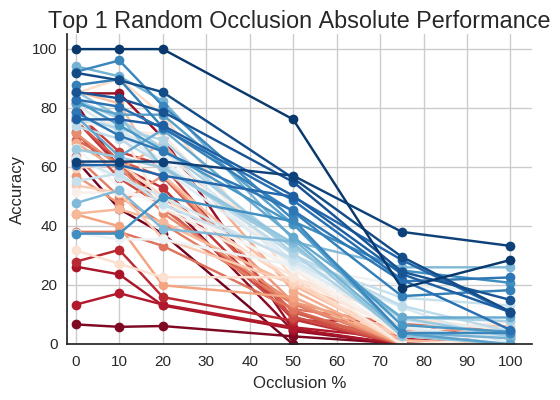

In [30]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4))    
mn = 'inceptionv3'
ds = 'random'
_,cats_inc =categories_plot(ax, mn, ds, "Random Occlusion Absolute Performance", False, "top1")
# _,cats_resn = categories_plot(ax[1], 'resnet50', ds, "Random Occlusion Absolute Performance (ResNet 50)", False, "top1")
fig.savefig('../figures/categories_all_abs_inception.pdf',bbox_inches='tight')

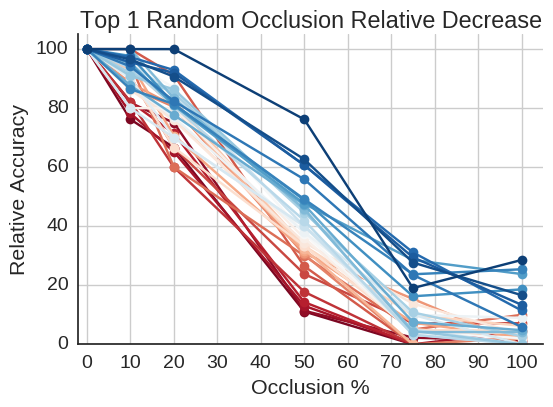

In [31]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4))    
mn = 'inceptionv3'
ds = 'random'
_,cats_inc =categories_plot(ax, mn, ds, "Random Occlusion Relative Decrease", True, "top1")
# _,cats_resn = categories_plot(ax[1], 'resnet50', ds, "Random Occlusion Performance Decrease (ResNet 50)", True, "top1")
fig.savefig('../figures/categories_all_rel_inception.pdf',bbox_inches='tight')

In [549]:
print(cats_inc)
# print(cats_resn)

[72, 188, 152, 158, 59, 175, 97, 44, 4, 134, 60, 99, 70, 105, 144, 43, 124, 58, 113, 2, 120, 179, 141, 37, 6, 157, 159, 21, 198, 20, 143, 34, 197, 26, 76]


In [556]:
cats

[CategoryData(idx=116, name='nail'),
 CategoryData(idx=162, name='soap dispenser'),
 CategoryData(idx=76, name='golf ball'),
 CategoryData(idx=68, name='flower pot'),
 CategoryData(idx=185, name='train'),
 CategoryData(idx=115, name='mushroom'),
 CategoryData(idx=26, name='bird'),
 CategoryData(idx=197, name='watercraft'),
 CategoryData(idx=34, name='butterfly'),
 CategoryData(idx=199, name='wine bottle'),
 CategoryData(idx=143, name='ray'),
 CategoryData(idx=166, name='squirrel'),
 CategoryData(idx=20, name='bear'),
 CategoryData(idx=198, name='whale'),
 CategoryData(idx=21, name='bee'),
 CategoryData(idx=159, name='snake'),
 CategoryData(idx=3, name='ant'),
 CategoryData(idx=157, name='skunk'),
 CategoryData(idx=6, name='armadillo'),
 CategoryData(idx=37, name='car'),
 CategoryData(idx=141, name='rabbit'),
 CategoryData(idx=56, name='digital clock'),
 CategoryData(idx=2, name='airplane'),
 CategoryData(idx=120, name='otter'),
 CategoryData(idx=179, name='tennis ball'),
 CategoryData(

In [552]:
db.det_categories[76]

DetCategory(idx=76, wnid='n03445777', name='golf ball', num_clsloc_cats=1, random_chance_top1=0.001, random_chance_top5=0.0050000000000000001, num=21)

In [484]:
db.det_categories[100]

DetCategory(idx=100, wnid='n03636649', name='lamp', num_clsloc_cats=1, random_chance_top1=0.001, random_chance_top5=0.0050000000000000001, num=34)

In [485]:
print(all_ds[-3])
print(all_ds)
models['resnet50'].datasets[all_ds[-3]].categories[100].top5_acc(True)

bb_random_050
['original', 'bb_random_010', 'bb_random_020', 'bb_random_050', 'bb_random_075', 'bb_center_100']


0.77777777777777779

In [558]:
accs1 = [[100*models['inceptionv3'].datasets[d].categories[idx].top1_acc(True) for d in all_ds] for idx in [116]]
accs1

[[100.0,
  92.307692307692307,
  92.307692307692307,
  92.307692307692307,
  53.846153846153847,
  46.153846153846153]]

In [495]:
models['resnet50'].datasets[all_ds[-3]].categories[100].num_top1(True)

6

# Image examples across categories

In [25]:
8/45

0.17777777777777778

In [23]:
models['inceptionv3'].datasets['bb_random_050'].categories[catid].num_top1(True)

45

In [33]:
catid = 59 # cat
ds = 'bb_random_050'
mn = 'inceptionv3'
c = models[mn].datasets[ds].categories[catid]

db_bb_file = os.path.join(bb_folder, "{}.h5".format(ds))
results_file = os.path.join(results, "preds_{}_{}.h5".format(mn, ds))

data_loader = ValDataLoader(db, (224,224), db_bb_file)

correct_original = c.num_top1(True)
cat_correct_guess = np.where(c.correct_top1)[0]
cat_wrong_guess = np.where(c.missed_mask_top1)[0]
print(len(cat_correct_guess), len(cat_wrong_guess), correct_original)



9 37 45


In [65]:
def show_img_and_preds(ds, idx):
    data_loader = ValDataLoader(db, (224,224), ds.bb_file)
    _, img = data_loader.prepare_img(idx, add_noise=True, show_bb=True)
    fig = plt.figure()
    ax1 = fig.add_axes((.1,.4,1,.8))
    
    ax1.set_title(syn_data.det_name_from_id(db.labels[idx]))
#     fig.text(0.1,0.1,"Hi there\nHi there 2")
    
#     print(get_readable_prediction(ds, syn_data, idx))
    for (d,c),p in get_readable_prediction(ds, syn_data, idx):
        print("{:.2f}: {} ({})".format(p, d, c))
    ax1.imshow(img)
    


0.41: skunk (id: 157) (skunk, polecat, wood pussy (id: 44))
0.12: dog (id: 58) (papillon (id: 43))
0.10: dog (id: 58) (Border collie (id: 128))
0.07: dog (id: 58) (Old English sheepdog, bobtail (id: 29))
0.05: monkey (id: 113) (colobus, colobus monkey (id: 54))


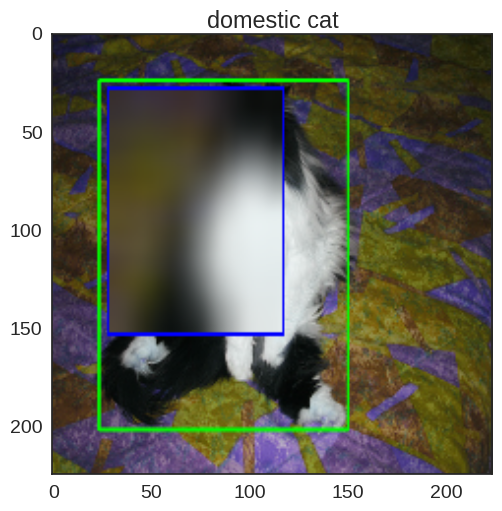

In [66]:
catid = 59 # cat
ds = 'bb_random_050'
mn = 'inceptionv3'
c = models[mn].datasets[ds].categories[catid]
correct_original = c.num_top1(True)
cat_correct_guess = np.where(c.correct_top1)[0]
cat_wrong_guess = np.where(c.missed_mask_top1)[0]
idx = cat_wrong_guess[5]
show_img_and_preds(c.dataset, idx)

0.46: domestic cat (id: 59) (tabby, tabby cat (id: 174))
0.19: domestic cat (id: 59) (tiger cat (id: 55))
0.11: domestic cat (id: 59) (Egyptian cat (id: 8))
0.01: tiger (id: 182) (tiger, Panthera tigris (id: 76))
0.01: - (badger (id: 16))


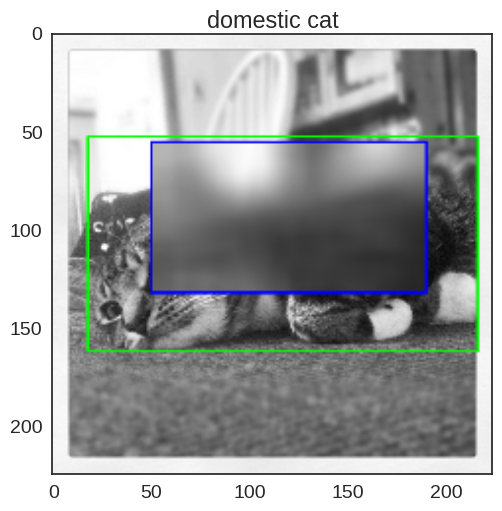

In [68]:
idx = cat_correct_guess[8]
show_img_and_preds(c.dataset, idx)